In [1]:
%pylab inline
# %load_ext memory_profiler

import os
import time
import warnings

import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import pygraphviz
from pomegranate import BayesianNetwork
from pomegranate.utils import plot_networkx
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering)
os.chdir('./notebooks')

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


# Aquisição dos dados

Segundo o artigo, eles usaram dados do índice Nikkey (**^N225**) e o da ação da Toyota (**7203.T**), entre 22/02/1985 e 30/12/2008.

In [2]:
df_nikkey = yf.download("^N225", start="1984-10-01", end="2008-12-30")

[*********************100%***********************]  1 of 1 completed


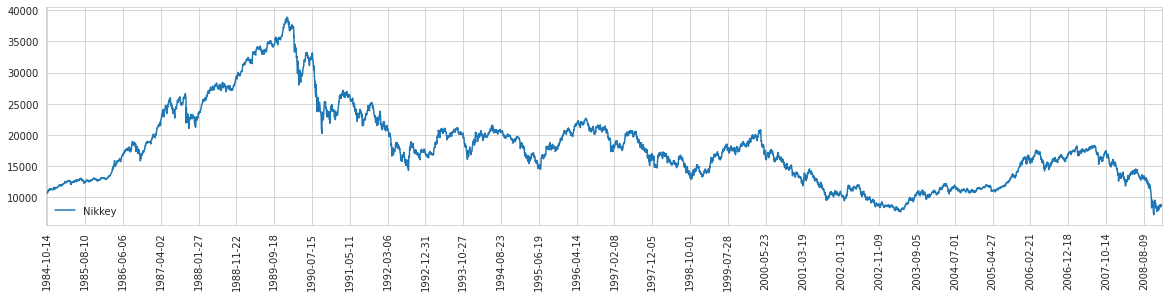

In [3]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_nikkey['Close'], label="Nikkey")

date_min = df_nikkey.index.min()
date_max = df_nikkey.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### IMPORTANTE!

Continuar somente com o Índice Nikkey 225, por enquanto. Pois não temos somente os dados da Toyota a partir de 1999.


## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (22/02/1985 até 30/11/2008) e de validação do modelo (01/12/2008 até 30/12/2008).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [24]:
df_teste = df_nikkey.copy()
df_teste.tail()
len(df_nikkey[:"2008-11-30"])

for i in np.arange(len(df_nikkey["2008-12-01":])):
    print(i)
    X_train = df_nikkey.iloc[:5956+i]
    X_test = df_nikkey[5956+i:5957+i]

    print(len(X_train), X_train.index[-1])
    print(len(X_test), X_test.index[-1])

0
5956 2008-11-28 00:00:00
1 2008-12-01 00:00:00
1
5957 2008-12-01 00:00:00
1 2008-12-02 00:00:00
2
5958 2008-12-02 00:00:00
1 2008-12-03 00:00:00
3
5959 2008-12-03 00:00:00
1 2008-12-04 00:00:00
4
5960 2008-12-04 00:00:00
1 2008-12-05 00:00:00
5
5961 2008-12-05 00:00:00
1 2008-12-08 00:00:00
6
5962 2008-12-08 00:00:00
1 2008-12-09 00:00:00
7
5963 2008-12-09 00:00:00
1 2008-12-10 00:00:00
8
5964 2008-12-10 00:00:00
1 2008-12-11 00:00:00
9
5965 2008-12-11 00:00:00
1 2008-12-12 00:00:00
10
5966 2008-12-12 00:00:00
1 2008-12-15 00:00:00
11
5967 2008-12-15 00:00:00
1 2008-12-16 00:00:00
12
5968 2008-12-16 00:00:00
1 2008-12-17 00:00:00
13
5969 2008-12-17 00:00:00
1 2008-12-18 00:00:00
14
5970 2008-12-18 00:00:00
1 2008-12-19 00:00:00
15
5971 2008-12-19 00:00:00
1 2008-12-22 00:00:00
16
5972 2008-12-22 00:00:00
1 2008-12-24 00:00:00
17
5973 2008-12-24 00:00:00
1 2008-12-25 00:00:00
18
5974 2008-12-25 00:00:00
1 2008-12-26 00:00:00
19
5975 2008-12-26 00:00:00
1 2008-12-29 00:00:00


In [48]:
X_train = df_nikkey[:"2008-11-30"]
X_test = df_nikkey["2008-12-01":]

print(f"""Base original: {df_nikkey.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_train = X_train[["Close", "rt"]][1:]
X_train.head()

Base original: (5976, 6)
X_train: (5956, 6)
X_test: (20, 6)



,Close,rt
Date,,
1984-10-02,10540.049805,-1.073343
1984-10-03,10587.379883,0.448045
1984-10-04,10642.070312,0.515233
1984-10-05,10737.580078,0.893470
1984-10-08,10676.929688,-0.566444


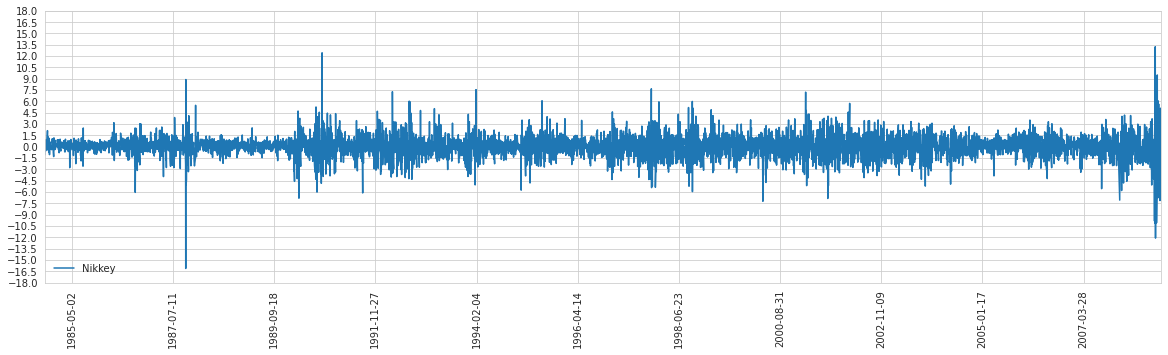

In [49]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label="Nikkey")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### Agrupamento dos $r_{t}$

**Agrupamentos uniformes**

In [51]:
X_train = binary_clustering(X_train[['rt']])
X_train.head()

,rt,cluster_rt
Date,,
1984-10-02,-1.073343,0
1984-10-03,0.448045,1
1984-10-04,0.515233,1
1984-10-05,0.893470,1
1984-10-08,-0.566444,0


Comparando agrupamento abtido com o agrupamento exposto no artigo.


![2012_zuo_table_01_uniform_clustering](../reports/figures/2012_zuo_table_01_uniform_clustering.png)

In [52]:
round(X_train.groupby(by=["cluster_rt"]).agg({"rt": ["min", "max","count", "mean"]}), 2).reset_index()

cluster_rt     rt                   
                min    max count  mean
0          0 -16.14   0.00  2915 -1.04
1          1   0.00  13.23  3040  0.99

### Adição de atributos conforme a rede bayesiana obtida

De acordo com os autores, usando o algoritmo K2, eles obtiveram a seguinte rede bayesiana:

``` dot

digraph G{
    rt-1 -> rt
    rt-5 -> rt
    rt-37 -> rt
}

```


Portanto, serão adicionados os seguintes atributos: **rt-1**, **rt-5** e **rt-37**, sendo que o número indica a quantidade de dias atrás que é necessário.

In [54]:
X_train = df_nikkey.loc[:"2008-11-30", ["Close"]]

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_train = create_shifted_rt(X_train, [1, 5, 37])
X_train = binary_clustering(X_train, ["rt", "rt-1", "rt-5", "rt-37"])

X_train = X_train["1985-02-22":]

X_train.head(10)

,Close,rt,rt-1,rt-5,rt-37,cluster_rt,cluster_rt-1,cluster_rt-5,cluster_rt-37
Date,,,,,,,,,
1985-02-22,12147.059570,0.153238,-0.196947,0.549730,0.020010,1,0,1,1
1985-02-25,12201.040039,0.443407,0.153238,0.007082,0.164989,1,1,1,1
1985-02-26,12194.969727,-0.049765,0.443407,0.061625,0.251814,0,1,1,1
1985-02-27,12287.379883,0.754916,-0.049765,-0.035127,0.003469,1,0,0,1
1985-02-28,12321.919922,0.280707,0.754916,-0.196947,0.130380,1,1,0,1
1985-03-01,12412.139648,0.729521,0.280707,0.153238,0.150949,1,1,1,1
1985-03-04,12509.009766,0.777417,0.729521,0.443407,0.896752,1,1,1,1
1985-03-05,12476.379883,-0.261192,0.777417,-0.049765,0.714749,0,1,0,1
1985-03-06,12498.669922,0.178499,-0.261192,0.754916,0.515600,1,0,1,1


Agora, vamos avaliar as métricas indicadas no artigo:

![2012_zuo_table_04_prediction_errors](../reports/figures/2012_zuo_table_04_prediction_errors.png)

![2012_zuo_rmse_cc](../reports/figures/2012_zuo_rmse_cc.png)

## Achando a estrutura da rede

In [72]:
sequencia = np.arange(1, 20, 2)
# sequencia = [1,5,37]
sequencia_rt = list(["rt-"+str(_) for _ in sequencia][::-1])
sequencia_rt.append('rt')

print(f"""\nTamanho da sequência: {len(sequencia)}
Sequência: {sequencia_rt}""")


Tamanho da sequência: 10
Sequência: ['rt-19', 'rt-17', 'rt-15', 'rt-13', 'rt-11', 'rt-9', 'rt-7', 'rt-5', 'rt-3', 'rt-1', 'rt']


In [73]:
X_train_network = X_train[["rt"]].copy()
X_train_network = create_shifted_rt(X_train_network, sequencia)
X_train_network = binary_clustering(X_train_network, sequencia_rt)

X_train_network.dropna(how="any", axis=0, inplace=True)
# X_train_network = X_train_network.sample(100, random_state=0).copy()
X_train_network = X_train_network.iloc[-1000:,]

lst_cluster = [column for column in X_train_network.columns if 'cluster_' in column]

print(f"Tamanho: {X_train_network.shape}")

X_train_network = X_train_network[lst_cluster].copy()

X_train_network.tail(5)

Tamanho: (1000, 22)


,cluster_rt-19,cluster_rt-17,cluster_rt-15,cluster_rt-13,cluster_rt-11,cluster_rt-9,cluster_rt-7,cluster_rt-5,cluster_rt-3,cluster_rt-1,cluster_rt
Date,,,,,,,,,,,
2008-11-21,0,1,1,1,0,1,0,1,0,0,1
2008-11-25,0,1,0,1,0,0,0,1,0,1,1
2008-11-26,1,1,1,0,1,0,1,0,0,1,0
2008-11-27,1,0,1,0,0,0,1,0,1,0,1
2008-11-28,1,1,0,1,0,1,0,0,1,1,1


Constraint Graph


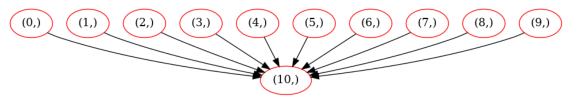

In [78]:
a = networkx.DiGraph()
b = lst_cluster.copy()
b.remove('cluster_rt')
# d = tuple([3])
# e = tuple([4])

for i, item in enumerate(b):
    a.add_edge(tuple([i]), tuple([X_train_network.columns.get_loc('cluster_rt')]))

print("Constraint Graph")
plt.figure(figsize=(10, 8))
plot_networkx(a)
plt.show()

Constraint Graph


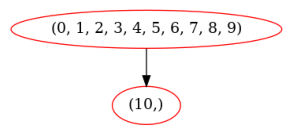

In [79]:
a = networkx.DiGraph()
b = lst_cluster.copy()
b.remove('cluster_rt')

a.add_edge(tuple(np.arange(len(X_train_network.columns[:-1]))), tuple([X_train_network.columns.get_loc('cluster_rt')]))

print("Constraint Graph")
plt.figure(figsize=(5, 5))
plot_networkx(a)
plt.show()

In [85]:
for algorith in ["exact", "greedy"]:
    model = BayesianNetwork.from_samples(
        X_train_network[lst_cluster], algorithm=algorith, state_names=lst_cluster, constraint_graph=a
        , reduce_dataset=False, n_jobs=-1, include_edges=
        )
    print(model.structure)
    plt.figure(figsize=(20, 5))
    model.plot()

TypeError: unsupported operand type(s) for /: 'str' and 'str'